<a href="https://colab.research.google.com/github/Aabha-J/Pytorch/blob/main/Computer_Vision_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Compiter Vision Libraries
- torchvision
- torchvision.datasets: data sets and data loading function
- torchvision.model: pre-trained models
- torchvision.transoform: manupliate images so they are usable for ML models
torch.utils.data.Dataset: base data set
torch.utils.data.DataLoader - creates iterable pytorch data set
- torchaudio, torchtest, torchRec also exist

In [6]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


##Data

In [7]:
#Training Data
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

#Testing Data
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

34804

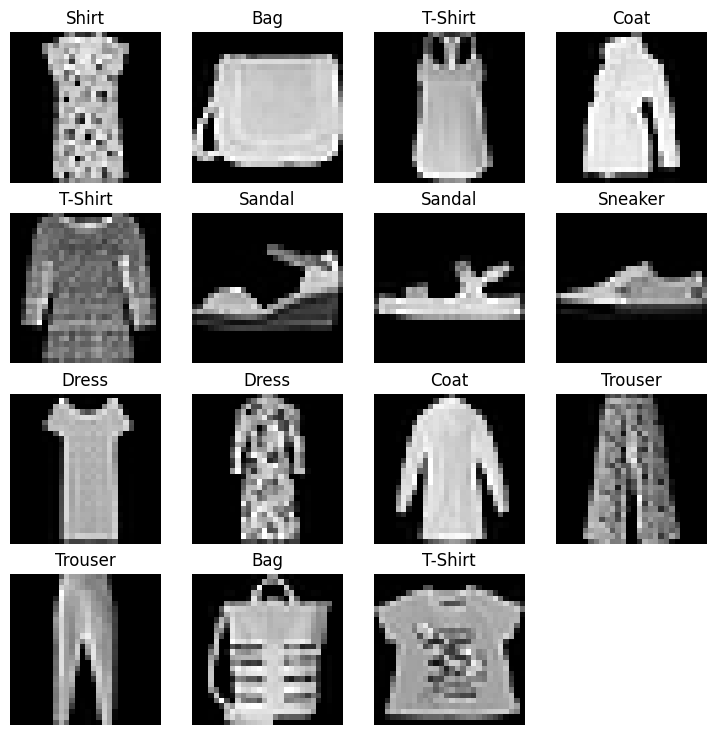

In [9]:
fig = plt.figure(figsize = (9,9))
rows, cols = 4,4

for i in range(1, rows*cols):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = 'gray')
  plt.title(labels_map[label])
  plt.axis(False)

torch.randint(0, len(train_data), size=[1]).item()

##Data Loader
- Batch sizes defined
- One epoch is too big so we divide it into smaller batches
- Speicify the number of training data examples presented each epoch

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, BATCH_SIZE, True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, False)

test_dataloader, train_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f304a050820>,
 <torch.utils.data.dataloader.DataLoader at 0x7f304a050370>)

##Model 0: Base Model

In [11]:
class FashionMNIST_model_v0(nn.Module):
  def __init__(self, input_shape:int, hidden_units: int, output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [12]:
model_0 = FashionMNIST_model_v0(input_shape = 28*28, hidden_units = 10, output_shape=len(labels_map))

Loss and Optimizer

In [13]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(params = model_0.parameters(), lr = 0.1)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct/len(y_pred))*100

Tracking Performance
- Track loss and accuarcy values
- Track how fast it runs

In [14]:
from timeit import default_timer as timer

In [15]:
def train_time(start:float, end:float):
  total_time = end - start
  return total_time

###Training Loop

1. Loop through epochs
2. Loop through training batches, calcuate train loss per batch
3. Loop through testing batches, calculate test loss per batch
5. Time it

In [16]:
from tqdm.auto import tqdm

start_time = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"epoch: {epoch}")

  train_loss = 0

  #Loop through training batches
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0,0
  model_0.eval()

  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_test, test_pred.argmax(dim = 1))

    test_loss /= len(test_data)
    test_acc /= len(test_dataloader)

  print(f"Train loss {train_loss:.4f} | Test loss {test_loss:.4f} | Test acc: {test_acc:.4f}")

end_time = timer()
model_0_train_time = train_time(start_time, end_time)
print(f"Time {model_0_train_time:.3f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
Train loss 0.5900 | Test loss 0.0162 | Test acc: 81.2700
epoch: 1
Train loss 0.4761 | Test loss 0.0172 | Test acc: 81.3498
epoch: 2
Train loss 0.4555 | Test loss 0.0154 | Test acc: 83.3167
Time 31.681 seconds


In [17]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn, device):
  loss, acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim = 1))

    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc":acc}


In [18]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device = "cpu"
)
model_0_results

{'model_name': 'FashionMNIST_model_v0',
 'model_loss': 0.4912183880805969,
 'model_acc': 83.31669329073482}

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Model 1
- Using non linearity

In [20]:
class FashionMNIST_model_v2(nn.Module):
  def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(nn.Flatten(),
                     nn.Linear(in_features = input_shape, out_features = hidden_units),
                     nn.ReLU(),
                     nn.Linear(in_features = hidden_units, out_features=output_shape),
                     nn.ReLU())
  def forward(self, x:torch.Tensor):
    return self.layer_stack(x)

In [21]:
pic_size = 28*28
hidden = 10
model_1 = FashionMNIST_model_v2(pic_size,hidden, len(labels_map)).to(device)

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model_1.parameters(), lr = 0.1)

In [23]:
def train(model:torch.nn.Module,
          data_loader:torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer:optim.Optimizer,
          accuracy_fn, device: torch.device):
  train_loss, train_acc = 0,0
  model.to(device)

  #Loop through training batches
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    model.train()
    y_pred = model(X)

    loss = loss_fn(y_pred, y)

    train_loss += loss
    train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")

def test(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         accuracy_fn, device: torch.device):
  test_loss, test_acc = 0, 0

  model.to(device)

  model.eval()

  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_test, test_pred.argmax(dim = 1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  print(f"Test loss {test_loss:.4f} | Test acc: {test_acc:.2f}%\n")



In [24]:
epochs = 3

optimizer = optim.SGD(params = model_1.parameters(), lr = 0.1)
loss_fn = nn.CrossEntropyLoss()

start_time = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")

    train(model = model_1, data_loader = train_dataloader,
          loss_fn = loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn,
          device = device
    )

    test(model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn, device = device
    )
end_time = timer()

model_1_train_time = train_time(start_time, end_time)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.04379 | Train accuracy: 65.86%

Test loss 0.8688 | Test acc: 71.81%

Epoch: 1
Train loss: 0.74590 | Train accuracy: 73.66%

Test loss 0.6761 | Test acc: 75.50%

Epoch: 2
Train loss: 0.66809 | Train accuracy: 75.60%

Test loss 0.6714 | Test acc: 75.34%



In [25]:
model_1_results = eval_model(model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn, device = device)
model_1_results

{'model_name': 'FashionMNIST_model_v2',
 'model_loss': 0.6713593602180481,
 'model_acc': 75.33945686900958}

##CNN
- Convelutional Neural Network

In [26]:
from torch.nn.modules.pooling import MaxPool2d
class FashionMNIST_model_v3(nn.Module):

   #conv 2d is for 2d data
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units,
                  kernel_size = 3,stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3,stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3,stride = 1, padding = 1),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3,stride = 1, padding = 1),
                  nn.ReLU(), nn.MaxPool2d(kernel_size = 2)
    )
    num = hidden_units*7*7
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=num, out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [27]:

model_2 = FashionMNIST_model_v3(
    input_shape = 1,
    hidden_units = 10,
    output_shape = len(labels_map)
).to(device)

In [28]:
optimizer = optim.SGD(params = model_2.parameters(), lr = 0.1)
loss_fn = nn.CrossEntropyLoss()

In [29]:
epochs = 3

start_time = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}")

  train(model = model_2, data_loader = train_dataloader,
          loss_fn = loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn,
          device = device
    )

  test(model=model_2,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      accuracy_fn=accuracy_fn, device = device
  )
end_time = timer()
model_2_train_time = train_time(start_time, end_time)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Train loss: 0.81917 | Train accuracy: 69.67%

Test loss 0.4251 | Test acc: 84.83%

Epoch 1
Train loss: 0.36516 | Train accuracy: 86.76%

Test loss 0.3614 | Test acc: 86.80%

Epoch 2
Train loss: 0.32414 | Train accuracy: 88.27%

Test loss 0.3460 | Test acc: 87.43%



In [30]:
model_2_results = eval_model(model_2, test_dataloader,loss_fn, accuracy_fn,device)

In [31]:
import pandas as pd
compare = pd.DataFrame([model_0_results, model_1_results, model_2_results])

In [33]:
compare['training time'] = [model_0_train_time, model_1_train_time, model_2_train_time]

In [34]:
compare

,model_name,model_loss,model_acc,training time
0,FashionMNIST_model_v0,0.491218,83.316693,31.681355
1,FashionMNIST_model_v2,0.671359,75.339457,35.240586
2,FashionMNIST_model_v3,0.346045,87.430112,43.039130


Text(0, 0.5, 'model')

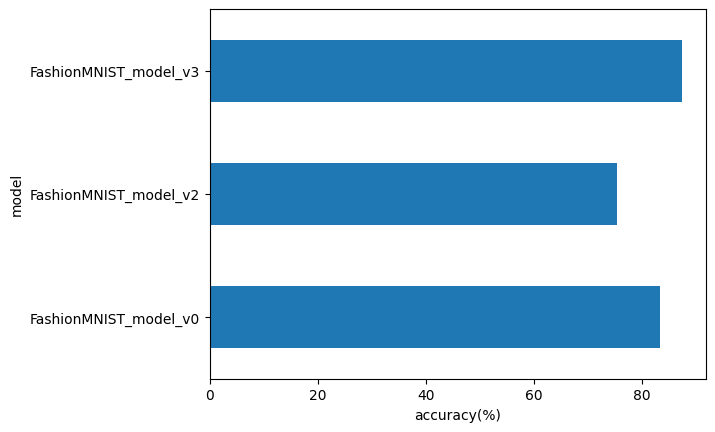

In [35]:

compare.set_index("model_name")["model_acc"].plot(kind = "barh")
plt.xlabel("accuracy(%)")
plt.ylabel("model")

In [36]:

def make_predictions(model: torch.nn.Module, data:list, device: torch.device):
  model.to(device)
  model.eval()

  pred_probs= []

  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())


  return torch.stack(pred_probs)



In [37]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)



In [38]:
device = "cpu"
pred_probs = make_predictions(model = model_2, data= test_samples, device = device)

In [39]:
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([7, 9, 0, 9, 1, 7, 1, 6, 6])

In [40]:
test_labels

[7, 9, 0, 9, 1, 7, 1, 6, 6]

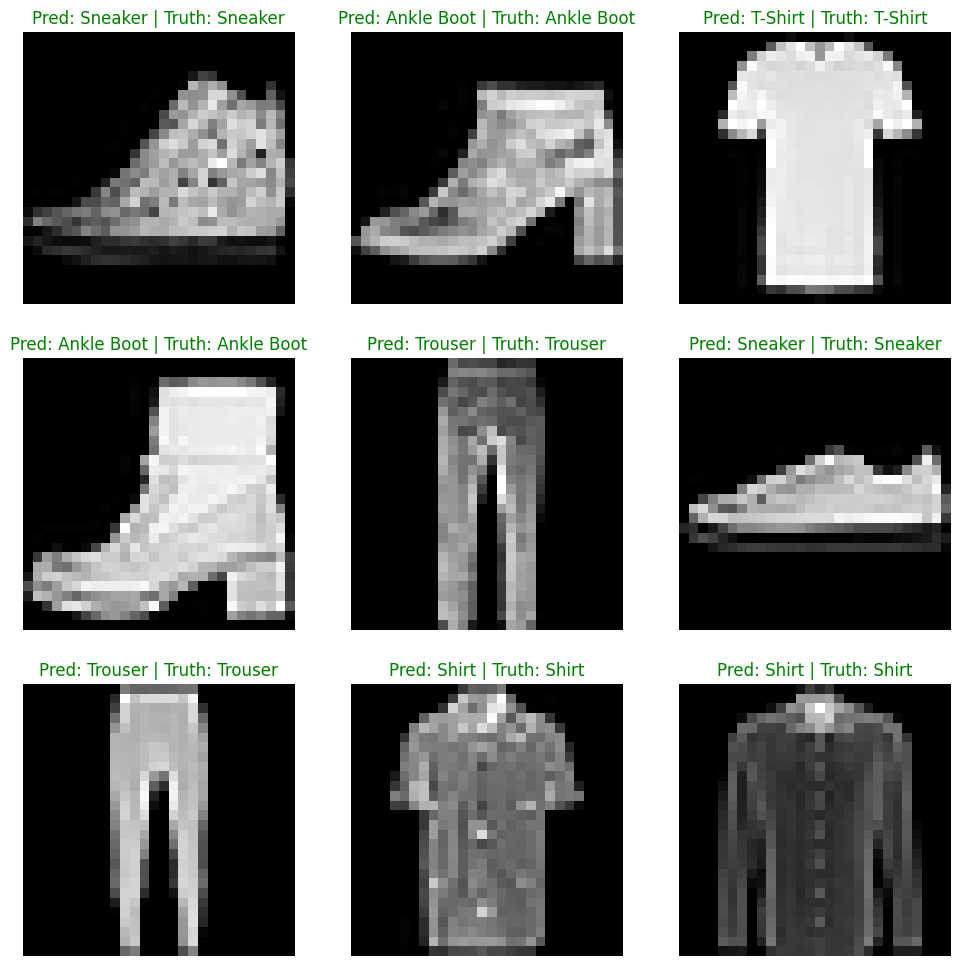

In [41]:
plt.figure(figsize = (12, 12))
nrows = 3
ncoloumns = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncoloumns, i+1)
  plt.imshow(sample.squeeze(), cmap = "gray")
  pred_label = labels_map[pred_classes[i].item()]
  truth_label = labels_map[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
    plt.title(title_text,c  = "g")
  else:
    plt.title(title_text,c  = "r")
  plt.axis(False)

##Confusion Matrix

- Evaluates classification models vsiaully

1. Make predicitions with test data
2. torch.metric.ConfusionMatrix
3. m1xtend.plotting.plot_confusion_matrix()

In [42]:
import mlxtend

In [43]:
from tqdm.auto import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc = 'Making predictions...'):
    y = y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim = 1)
    y_preds.append(y_pred.cpu())




Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

In [45]:
!pip install -q torchmetrics -U mlxtend

In [46]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [53]:
confmat = ConfusionMatrix(num_classes=len(labels_map), task="multiclass")
confmat_tensor = confmat(preds = torch.cat(y_preds),
                         target = test_data.targets)

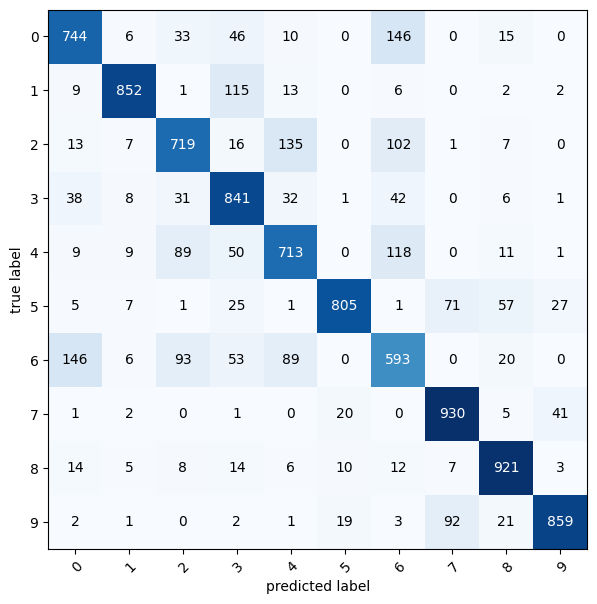

In [62]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names = labels_map,
    figsize = (10,7)
)